## Setup

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models
from torch import Tensor

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


In [2]:
from matplotlib import colors
import matplotlib.legend_handler as lh
from matplotlib.lines import Line2D
import os
import matplotlib


def get_tab10_legend():
    # Get the tab10 colormap
    try:
        tab10 = matplotlib.colormaps["tab10"].colors
    except AttributeError:
        tab10 = matplotlib.cm.get_cmap("tab10").colors

    # Convert RGB to hex values
    colors_hex = [colors.rgb2hex(color) for color in tab10]
    custom_lines = [
        Line2D([0], [0], color=colors_hex[i], lw=4, alpha=0.6)
        for i in range(len(colors_hex))
    ]

    return custom_lines, colors_hex


In [3]:
# semantic_masks
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import torch


def semantic_masks(image, masks, titles: list[str] = [], fig_size: tuple = (10, 10)):
    if len(masks) > len(titles):
        titles = titles

    custom_lines, colors_hex = get_tab10_legend()

    drawn_masks = draw_segmentation_masks(image, masks, alpha=0.4, colors=colors_hex)

    fig, axs = plt.subplots()  # figsize=fig_size
    lines = axs.imshow(torch.einsum("chw -> hwc", drawn_masks))
    fig.legend(
        custom_lines,
        [x.replace("_", " ") for x in titles],
        loc="lower center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
    )

    fig.tight_layout()
    plt.show()

    return fig, axs


In [4]:
# semantic_masks_no_tissue
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import torch


def semantic_masks_no_tissue(
    image, masks, titles: list[str] = [], fig_size: tuple = (10, 10)
):
    masks = masks[1:]
    if len(masks) > len(titles):
        titles = titles

    custom_lines, colors_hex = get_tab10_legend()

    drawn_masks = draw_segmentation_masks(image, masks, alpha=0.4, colors=colors_hex)

    fig, axs = plt.subplots(figsize=(6, 6))  # figsize=fig_size
    lines = axs.imshow(torch.einsum("chw -> hwc", drawn_masks))
    axs.legend(
        custom_lines,
        [x.replace("_", " ") for x in titles],
        loc="center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=2,
    )
    axs.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        right=False,
        left=False,
        labelleft=False,
    )
    fig.tight_layout()
    # plt.show()

    return fig, axs


In [5]:
# plot the first image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms


def plot_image(
    image,
    mask,
    titles: list[str] = [],
):
    """Plot a single image and its associated mask"""

    fig, axs = plt.subplots(1, len(mask) + 1, figsize=(20, 20))
    axs[0].imshow(image.permute(1, 2, 0))
    for i in range(1, len(mask) + 1):
        axs[i].imshow(mask[i - 1].unsqueeze(-1), cmap="gray", vmin=0, vmax=1)  #
        plt.setp(axs[i].get_yticklabels(), visible=False)
    for ax in axs:
        ax.xaxis.tick_top()
    for ax, title in zip(axs, titles):
        ax.set_xlabel(title)

    fig.tight_layout()
    plt.show()

    return fig, axs


In [6]:
def split_and_denormalize_batch(sample):

    if len(sample['data'].shape) == 3:
        sample["data"] = sample["data"].squeeze()

    image, masks = sample["data"][:,:3], sample["data"][:,3:]

    print(image.shape, masks.shape)

    # unnormalize
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    image = image * std[None, :, None, None] + mean[None, :, None, None]
    # remove background, mask[0] == tissue
    image = image * masks[:,0]
    img = (image * 255).type(torch.uint8)
    # black -> white
    img[img == 0] = 255
    # to bool
    masks = masks.type(torch.bool)

    return img, masks


In [7]:
def split_and_denormalize(sample):
    image, masks = sample["data"].squeeze()[:3], sample["data"].squeeze()[3:]

    # unnormalize
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    # remove background, mask[0] == tissue
    image = image * masks[0]
    img = (image * 255).type(torch.uint8)
    # black -> white
    img[img == 0] = 255
    # to bool
    masks = masks.type(torch.bool)

    return img, masks


In [8]:
def attribute_image_features(algorithm, input, net, target, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=target, **kwargs)

    return tensor_attributions


## config and data

In [9]:
config = {
    "seed": 42,
    "batch_size": 1,
    "target_level": 3,
    "num_workers": 10,
    "base_dir": "/media/sciobiome/DATA/sklein_tmp/",
    "overfit": 1.0,
    "data_split": [0.8, 0.15, 0.05],
    "annos_of_interest": [
        "Tissue",
        "Tumor_vital",
        "Angioinvasion",
        "Tumor_necrosis",
        "Tumor_regression",
    ],
    "cache_path": "/media/sciobiome/DATA/sklein_tmp/cached_DownsampleDataset_level_3.json",
}


In [10]:
import numpy as np

import torch
from torch import nn

from src.datasets.base_dataset import dataset_globber
from src.datasets.downsample_dataset import DownsampleMaskDataset

from torchvision import transforms
from torch.utils.data import random_split, DataLoader

input_dicts = dataset_globber(
    config["base_dir"] + "data", #"Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/",
    config["base_dir"] + "survival_status.csv",
)

img_transform = transforms.Compose(
    [
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.0),
    ]
)

stack_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        # transforms.RandomRotation((0, 180))
    ]
)

config["total_samples"] = len(input_dicts)
config["inputs"] = input_dicts

dataset: DownsampleMaskDataset = DownsampleMaskDataset(
    input_dicts,
    foreground_key="Tissue",
    image_key="image",
    label_key="surv_days",
    keys=config["annos_of_interest"],
    censor_key="uncensored",
    json_key="geojson",
    # cache=True,
    # cache_file=config["cache_path"],
    target_level=config["target_level"],
    transform1=img_transform,
    transform2=stack_transform,
)

train_ds, val_ds, test_ds = random_split(
    dataset,
    config["data_split"],
    generator=torch.Generator().manual_seed(int(config["seed"])),
)

config = config | {
    "train_size": len(train_ds),
    "val_size": len(val_ds),
    "test_size": len(test_ds),
}

dataloader_train = DataLoader(
    train_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
    sampler=None,
)
dataloader_eval = DataLoader(
    val_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)
dataloader_test = DataLoader(
    test_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)


2023-04-24 17:53:10.286211: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Cache: False
Cache file: 
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-013.001~C-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-013.016~E-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-013.019~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-013.041~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-013.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-018.001~I-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-018.016~B-Tissue.tif


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-018.019~E-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-018.041~C-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-018.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-021.001~D-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-021.016~E-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-021.019~H-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-021.041~B-Tissue.tif


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-021.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-111.001~G-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-111.016~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-111.019~B (2)-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-111.041~C-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-111.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-121-016~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-121.001~C-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-121.019~B-Tissue.tif


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-121.041~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-121.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-129.001~C-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-129.016~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-129.019~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-129.041~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-129.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-158.001~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-158.016~B-Tissue.tif


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-158.019~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-158.041~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-158.042~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-181.001~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-181.016~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-181.019~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-181.041~B-Tissue.tif
/media/sciobiome/DATA/sklein_tmp/data/RCC-TA-181.042~B-Tissue.tif


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

In [11]:
from src.networks.pathology import CoxResNet

model = CoxResNet(input_channels=8, feature_size=1000)
# model = model.eval()

# load model from file
model.load_state_dict(
    torch.load(
        config["base_dir"] + "2023-04-14_lr_0.01_2_fc_layer_CI.pth",
        map_location=torch.device("cpu"),
    )["model_state_dict"]
)
# model.load_state_dict(torch.load('/data2/projects/DigiStrudMed_sklein/huggingface/2023-04-03_None_no_scheduler_CPH.pth'))

# model = model.eval()


DEBUG:git.cmd:Popen(['git', 'version'], cwd=/media/sciobiome/DATA/sklein_tmp/renal-cancer-dl/notebooks, universal_newlines=False, shell=None, istream=None)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/media/sciobiome/DATA/sklein_tmp/renal-cancer-dl/notebooks, universal_newlines=False, shell=None, istream=None)
DEBUG:wandb.docker.auth:Trying paths: ['/home/sciobiome/.docker/config.json', '/home/sciobiome/.dockercfg']
DEBUG:wandb.docker.auth:No config file found
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpkx298f3f
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpkx298f3f/_remote_module_non_scriptable.py


<All keys matched successfully>

In [12]:
import itertools


batch = next(itertools.islice(dataloader_train, 6, None)) # next(iter(dataloader_train))
image, masks = split_and_denormalize(batch)


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 4

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 no

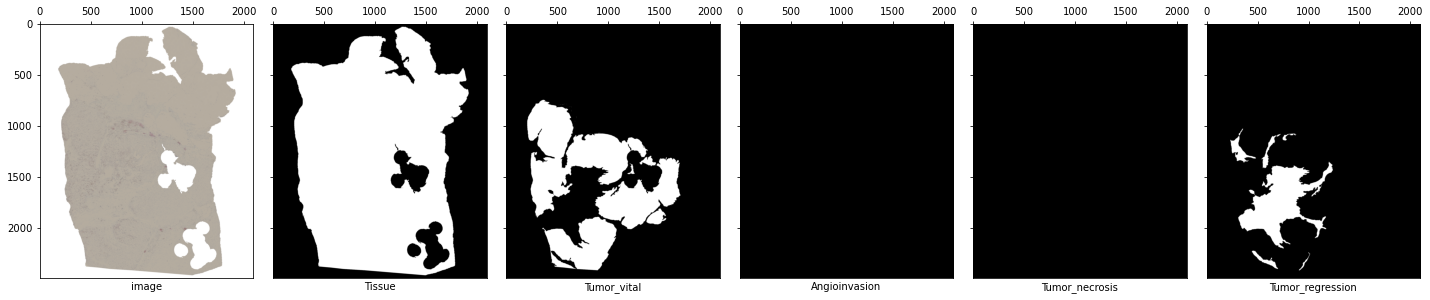

(<Figure size 1440x1440 with 6 Axes>,
 array([<AxesSubplot:xlabel='image'>, <AxesSubplot:xlabel='Tissue'>,
        <AxesSubplot:xlabel='Tumor_vital'>,
        <AxesSubplot:xlabel='Angioinvasion'>,
        <AxesSubplot:xlabel='Tumor_necrosis'>,
        <AxesSubplot:xlabel='Tumor_regression'>], dtype=object))

In [13]:
plot_image(image, masks, titles=["image"] + config["annos_of_interest"])


In [14]:
red_cmap = LinearSegmentedColormap.from_list(
    "custom red", [(0, "#ffffff"), (0.25, "#C7030D"), (1, "#C7030D")], N=256
)
green_cmap = LinearSegmentedColormap.from_list(
    "custom green", [(0, "#ffffff"), (0.25, "#007D0B"), (1, "#007D0B")], N=256
)
blue_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "blue"), (1, "blue")], N=256
)
duo_cmap = LinearSegmentedColormap.from_list('Random gradient 9655', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%209655=0:C7030D-40:BC3B3B-50:FFFFFF-60:8BBE90-100:007D0B
    (0.000, (0.780, 0.012, 0.051)),
    (0.400, (0.737, 0.231, 0.231)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.600, (0.545, 0.745, 0.565)),
    (1.000, (0.000, 0.490, 0.043))))

## Baseimage

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


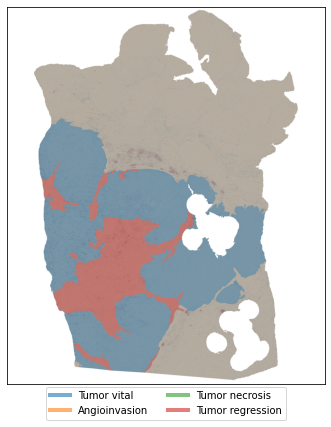

In [15]:
path = "../assets/captum/"
# basename = f"case{batch['case_id'].item()}-stain{batch['stain_id'].item()}-{'dead' if batch['uncensored'].item() else 'censored'}_{int(batch['surv_days'].item())}days"
basename = f"case{batch['case_id'].item()}-stain{batch['stain_id'].item()}-{'dead' if batch['uncensored'].item() else 'censored'}_{int(batch['surv_days'].item())}days"

fig, axs = semantic_masks_no_tissue(
    image, masks, titles=config["annos_of_interest"][1:]
)
fig.savefig(dpi=300, fname=f"{path}masks_{basename}.png")


### Integrated Gradient Based Attribution

In [16]:
def wrapped_model(inp):
    return model(inp)[1]


integrated_gradients = IntegratedGradients(wrapped_model)
attributions_ig = integrated_gradients.attribute(
    batch["data"].clone(),
    n_steps=50,
    internal_batch_size=config["batch_size"],
    # target=0,
)


The outlier_perc argument controls the level of clipping applied to the attribution values before visualization. Specifically, outlier_perc determines the percentage of attribution values that will be clipped to the minimum and maximum values, respectively.

For example, if outlier_perc=5, then the 5% of attribution values with the smallest magnitude will be set to the minimum value, and the 5% of attribution values with the largest magnitude will be set to the maximum value. This can be useful for enhancing the visualization of important features and reducing the impact of noisy or irrelevant features.

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f570c5ee650>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f570c5ee650> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


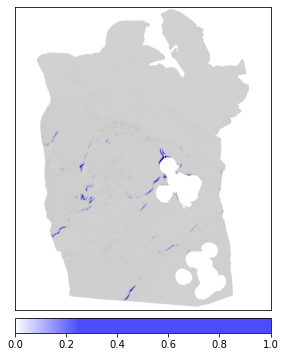

In [17]:
method = "integrated_gradients"

fig_duo, ax_duo = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=blue_cmap,
    alpha_overlay=0.7,
    show_colorbar=True,
    sign="absolute_value",
    outlier_perc=2,
    use_pyplot=False,
)

fig_duo.savefig(dpi=300, fname=f"{path}{method}_abs_{basename}.png")
fig_duo

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f570483b370>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f570483b370> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


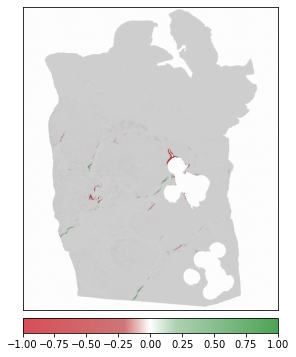

In [18]:
method = "integrated_gradients"

import matplotlib as mpl
mpl.colors.Colormap("viridis")

fig_duo, ax_duo = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=duo_cmap,
    alpha_overlay=0.7,
    show_colorbar=True,
    sign="all",
    outlier_perc=2,
    use_pyplot=False,
)

fig_duo.savefig(dpi=300, fname=f"{path}{method}_both_{basename}.png")
fig_duo

## GradCAM

In [19]:
from captum.attr import GuidedGradCam


In [20]:
# class WrappedModel(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)[1]


# wrapped_model = WrappedModel(model)

# grad_cam = GuidedGradCam(wrapped_model, model.non_linear_downsample[0]) #model.non_linear_downsample[0]
# attributions_gradcam = grad_cam.attribute(
#     batch["data"].clone(),
#     # target=0,
# )


# fig_pos, ax_pos = viz.visualize_image_attr(
#     np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=duo_cmap,
#     show_colorbar=True,
#     alpha_overlay=0.7,
#     sign="all",
#     outlier_perc=2,
#     use_pyplot=False,
#     # title="Guided GradCam",
# )

# fig_pos

In [24]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[1]


wrapped_model = WrappedModel(model)

grad_cam = GuidedGradCam(wrapped_model, model.resnet.layer4[-1].conv3 ) # model.resnet.layer4[-1].conv3 #model.non_linear_downsample[0]
attributions_gradcam = grad_cam.attribute(
    batch["data"].clone(),
    attribute_to_layer_input=True,
    interpolate_mode="area"
)


/home/sciobiome/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/sciobiome/captum/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [25]:
print(attributions_gradcam.unique(return_counts=True))

(tensor([-0.0955, -0.0922, -0.0789,  ...,  0.0316,  0.0367,  0.0369],
       grad_fn=<Unique2Backward0>), tensor([1, 1, 1,  ..., 1, 1, 1]))


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760b173a0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760b173a0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


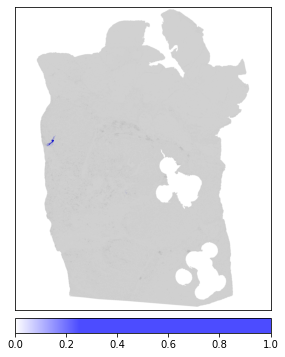

In [34]:

method = "guided_gradcam"

fig_pos, ax_pos = viz.visualize_image_attr(
    np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=blue_cmap,
    show_colorbar=True,
    alpha_overlay=0.7,
    sign="absolute_value",
    outlier_perc=10,
    use_pyplot=False,
    # title="Guided GradCam",
)

fig_pos.savefig(dpi=300, fname=f"{path}{method}_abs_{basename}.png")
fig_pos

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57610a4280>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57610a4280> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


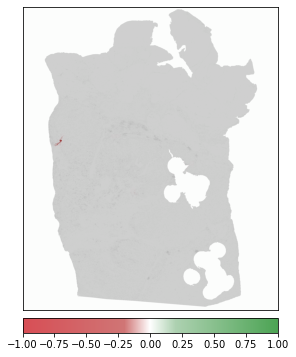

In [27]:

method = "guided_gradcam"

fig_pos, ax_pos = viz.visualize_image_attr(
    np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=duo_cmap,
    show_colorbar=True,
    alpha_overlay=0.7,
    sign="all",
    outlier_perc=10,
    use_pyplot=False,
    # title="Guided GradCam",
)

fig_pos.savefig(dpi=300, fname=f"{path}{method}_both_{basename}.png")
fig_pos

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760bd5090>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760bd5090> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


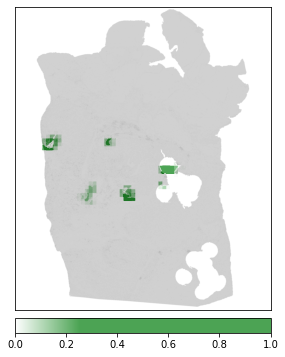

In [35]:
fig_pos, ax_pos = viz.visualize_image_attr(
    np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=green_cmap,
    show_colorbar=True,
    alpha_overlay=0.7,
    sign="positive",
    outlier_perc=10,
    use_pyplot=False,
)

fig_pos.savefig(dpi=300, fname=f"{path}{method}_pos_{basename}.png")
fig_pos

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760bf8400>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5760bf8400> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


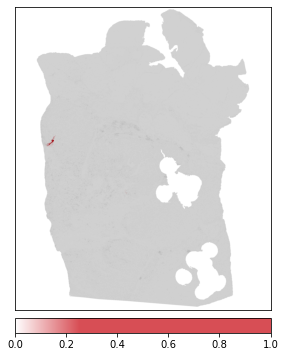

In [36]:
fig_neg, ax_neg = viz.visualize_image_attr(
    np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    cmap=red_cmap,
    method="blended_heat_map",
    show_colorbar=True,
    alpha_overlay=0.7,
    sign="negative",
    outlier_perc=10,
    use_pyplot=False,
)
fig_neg.savefig(dpi=300, fname=f"{path}{method}_neg_{basename}.png")
fig_neg

## Saliency

In [38]:
from captum.attr import Saliency

saliency = Saliency(wrapped_model)
sal_attribution = saliency.attribute(
    torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0)
)
sal_attribution.shape


torch.Size([1, 8, 2491, 2094])

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57609488e0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57609488e0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


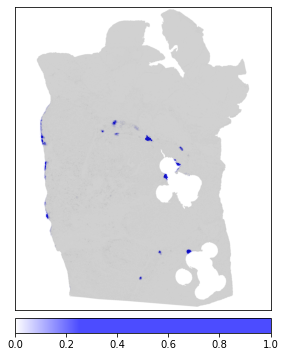

In [39]:
method = "saliency"

fig_sal, ax_sal = viz.visualize_image_attr(
    np.transpose(sal_attribution.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=blue_cmap,
    alpha_overlay=0.7,
    show_colorbar=True,
    sign="absolute_value",
    outlier_perc=10,
    use_pyplot=False,
)
fig_sal.savefig(dpi=300, fname=f"{path}{method}_{basename}.png")
fig_sal


## Input X gradient

In [40]:
from captum.attr import InputXGradient

inxgrad = InputXGradient(wrapped_model)
inxgrad_attr = inxgrad.attribute(
    torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0)
)
inxgrad_attr.shape


torch.Size([1, 8, 2491, 2094])

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57609d7550>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f57609d7550> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


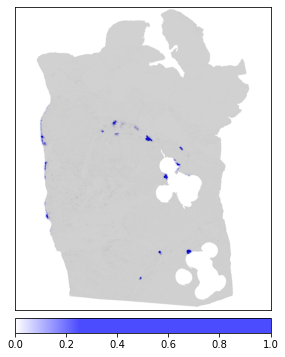

In [41]:
method = "inputXgradient"

fig_ixg, ax_ixg = viz.visualize_image_attr(
    np.transpose(inxgrad_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    cmap=blue_cmap,
    show_colorbar=True,
    alpha_overlay=0.7,
    sign="absolute_value",
    outlier_perc=10,
    use_pyplot=False,
)
fig_ixg.savefig(dpi=300, fname=f"{path}{method}_pos_{basename}.png")
fig_ixg


## GuidedBackprop

In [ ]:
# from captum.attr import GuidedBackprop

# method = "GuidedBackprop"

# guideBp = GuidedBackprop(wrapped_model)
# guideBp_attr = guideBp.attribute(
#     torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0)
# )
# guideBp_attr.shape


In [ ]:
# fig_neg, ax_neg = viz.visualize_image_attr(
#     np.transpose(guideBp_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=default_cmap,
#     show_colorbar=True,
#     sign="negative",
#     outlier_perc=10,
#     use_pyplot=False,
# )
# fig_neg.savefig(dpi=300, fname=f"{path}{method}_neg_{basename}.png")
# fig_neg


In [ ]:
# fig_pos, ax_pos = viz.visualize_image_attr(
#     np.transpose(guideBp_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=default_cmap,
#     show_colorbar=True,
#     sign="positive",
#     outlier_perc=5,
#     use_pyplot=False,
# )
# fig_pos.savefig(dpi=300, fname=f"{path}{method}_pos_{basename}.png")
# fig_pos


## Layer-wise relevance propagation

In [ ]:
# from captum.attr import LRP
# method = "LayRelevProp"

# lrp = LRP(wrapped_model)
# lrp_attr = lrp.attribute(torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0))
# lrp_attr.shape

In [ ]:
# fig_pos, ax_pos = viz.visualize_image_attr(
#     np.transpose(lrp_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=default_cmap,
#     show_colorbar=True,
#     sign="positive",
#     outlier_perc=10,
#     use_pyplot=False,
# )
# fig_pos.savefig(dpi=300, fname=f"{path}{method}_pos_{basename}.png")
# fig_pos


In [ ]:
# fig_neg, ax_neg = viz.visualize_image_attr(
#     np.transpose(lrp_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     # np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=default_cmap,
#     show_colorbar=True,
#     sign="negative",
#     outlier_perc=10,
#     use_pyplot=False,
# )
# fig_neg.savefig(dpi=300, fname=f"{path}{method}_neg_{basename}.png")
# fig_neg


## Feature Ablation

In [ ]:
# from captum.attr import FeatureAblation

# method = "FeatureAblation"

# feat_abl = FeatureAblation(wrapped_model)
# feat_abl_attr = feat_abl.attribute(
#     torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0),
#     show_progress=True,
# )
# feat_abl_attr.shape


Feature Ablation attribution:   0%|          | 0/41729233 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# fig_neg, ax_neg = viz.visualize_image_attr(
#     np.transpose(feat_abl_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=blue_cmap,
#     show_colorbar=True,
#     sign="absolute_value",
#     outlier_perc=2,
#     use_pyplot=False,
# )
# fig_neg.savefig(dpi=300, fname=f"{path}{method}_neg_{basename}.png")
# fig_neg


## Occlusion

In [46]:
from captum.attr import Occlusion

method = "Occlusion"

occl2 = Occlusion(wrapped_model)
occl_attr2 = occl2.attribute(
    torch.cat([image, masks.type(torch.float)], dim=0).unsqueeze(0),
    sliding_window_shapes=(8, 100, 100),
    strides=(8, 100, 100),
    show_progress=True,
)
occl_attr2.shape


Occlusion attribution:   0%|          | 0/526 [00:00<?, ?it/s]

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5750d56bf0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5750d56bf0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


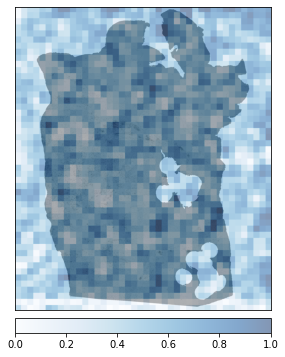

In [45]:
fig_pos, ax_pos = viz.visualize_image_attr(
    np.transpose(occl_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
    method="blended_heat_map",
    # cmap=blue_cmap,
    show_colorbar=True,
    sign="absolute_value",
    outlier_perc=2,
    use_pyplot=False,
)
fig_pos.savefig(dpi=300, fname=f"{path}{method}_pos_{basename}.png")
fig_pos


In [ ]:
# fig_neg, ax_neg = viz.visualize_image_attr(
#     np.transpose(occl_attr.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(image.cpu().detach().numpy(), (1, 2, 0)),
#     method="blended_heat_map",
#     cmap=default_cmap,
#     show_colorbar=True,
#     sign="negative",
#     outlier_perc=10,
#     use_pyplot=False,
# )
# fig_neg.savefig(dpi=300, fname=f"{path}{method}_neg_{basename}.png")
# fig_neg
